In [1]:
#Load all the necessary packages for the wrangling part of the project
import requests
from pathlib import Path
from eod import EodHistoricalData
from twelvedata import TDClient
import datetime as dt
import pandas as pd
import numpy as np
import numpy.random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [33]:
import json

## Part 1

In [34]:
f = open('logins.json')
data = json.load(f)
df = pd.DataFrame(data)

In [35]:
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [36]:
df.dtypes

login_time    object
dtype: object

In [74]:
df.login_time = pd.to_datetime(df.login_time)
df.index = pd.to_datetime(df.login_time)
group = df.groupby(pd.Grouper(freq='15Min')).agg('count')
group['ma'] = group['login_time'].rolling(96).sum()
group['time'] = group.index

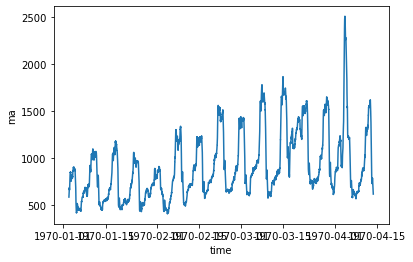

In [75]:
sns.lineplot(
    x='time',
    y='ma',
    data=group)
plt.show()

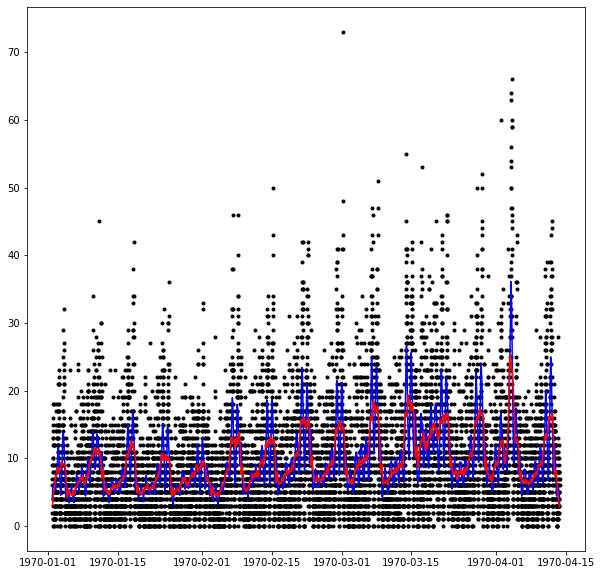

In [79]:
def window_lag(size):
    return np.ones(size)/float(size)

# assign data
timepart = group.index
height = group.iloc[:,0]
_ = plt.figure(figsize=(10,10))
plt.plot(timepart,height,'k.')
plt.plot(timepart,np.convolve(height,window_lag(50),'same'),'b')
plt.plot(timepart,np.convolve(height,window_lag(100),'same'),'r')
plt.show()

In [81]:
group['time_during_week']=group['time'].dt.strftime('%H:%M:%S') 

In [106]:
by_time_of_the_day = group.groupby('time_during_week').agg('sum')

In [107]:
by_time_of_the_day

,login_time,ma
time_during_week,,
00:00:00,1439,92637.0
00:15:00,1547,92627.0
00:30:00,1525,92623.0
00:45:00,1482,92614.0
01:00:00,1549,92611.0
...,...,...
22:45:00,1637,92657.0
23:00:00,1573,92648.0
23:15:00,1552,92647.0


In [110]:
%matplotlib inline

In [152]:
by_time_of_the_day.index

Index(['00:00:00', '00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00',
       '01:30:00', '01:45:00', '02:00:00', '02:15:00', '02:30:00', '02:45:00',
       '03:00:00', '03:15:00', '03:30:00', '03:45:00', '04:00:00', '04:15:00',
       '04:30:00', '04:45:00', '05:00:00', '05:15:00', '05:30:00', '05:45:00',
       '06:00:00', '06:15:00', '06:30:00', '06:45:00', '07:00:00', '07:15:00',
       '07:30:00', '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00',
       '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00',
       '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00',
       '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00',
       '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00',
       '15:00:00', '15:15:00', '15:30:00', '15:45:00', '16:00:00', '16:15:00',
       '16:30:00', '16:45:00', '17:00:00', '17:15:00', '17:30:00', '17:45:00',
       '18:00:00', '18:15:00', '18:30:00', '18:45:00

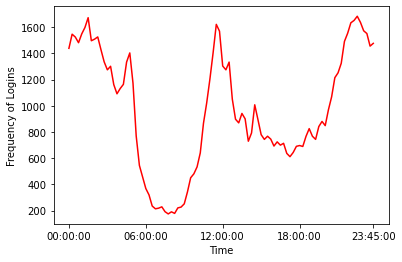

In [170]:
from matplotlib.dates import DateFormatter, DayLocator

_ = plt.figure()
_ = plt.plot(by_time_of_the_day.index, by_time_of_the_day.login_time, color='red')
_ = plt.xlabel("Time")
_ = plt.ylabel("Frequency of Logins")
_ = plt.xticks([0, int(len(by_time_of_the_day)*0.25),int(len(by_time_of_the_day)*0.5),int(len(by_time_of_the_day)*0.75), len(by_time_of_the_day)-1])
_ = plt.show()

In [167]:
print("From this graph, we can see that the user logs in more often at noon and midnight, near 12am and 12pm.")

From this graph, we can see that the user logs in more often at noon and midnight, near 12am and 12pm.


## Part 2

### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I believe two types of measure would prove success of this experiement. First is the total amount of trip taken between these two cities for companies like Uber and Lyft, and if there are more trips from online taxi services company, it could imply that more drivings are happening between the two cities. The other metric is the total nubmer of cars coming in both cities.

### 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### a) how you will implement the experiment

I will try to compare the metrics of my choice, which are data of trips taken between the cities from Uber or Lyft or data of the total number of times cars entered the toll.

#### b) what statistical test(s) you will conduct to verify the significance of the observation

I will use a paired t-test to verify the siginificance of the observation

#### 3) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If there were to be a significant increase in the total number of times cars enter both cities, we could interpret the result as a success. 

In this scenario, our null hypothesis is that the average number of times cars enter both cities remains the same after implementing the new policy, and our alternative hypothesis is that after implementing the new policy, the avergae number of times cars enter both cities is greater than that before implementing the new policy

## Part 3

In [172]:
f1 = open('ultimate_data_challenge.json')
data1 = json.load(f1)
dfu = pd.DataFrame(data1)

In [173]:
dfu

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [178]:
print(dfu['last_trip_date'].max() + ' is the last day of the dataset, so anyone that had a trip between 2014-06-01 to 2014-07-01 are considered to be active')

2014-07-01 is the last day of the dataset, so anyone that had a trip between 2014-06-01 to 2014-07-01 are considered to be active


### 3.1 EDA and Data Wrangling

#### For avg_rating_of_driver, we will fill the na with the median values

(array([2.560e+02, 7.000e+00, 2.180e+02, 1.200e+02, 1.000e+02, 1.404e+03,
        1.452e+03, 4.846e+03, 5.415e+03, 2.806e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

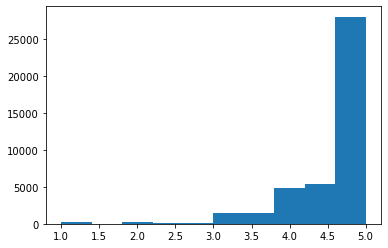

In [186]:
plt.hist(dfu['avg_rating_of_driver'])

In [183]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [187]:
dfu['avg_rating_of_driver'].fillna(dfu['avg_rating_of_driver'].median(), inplace=True)

#### We will drop the phone variable

In [190]:
dfu = dfu[[i for i in dfu.columns if i not in 'phone']]

In [192]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   surge_pct               50000 non-null  float64
 7   ultimate_black_user     50000 non-null  bool   
 8   weekday_pct             50000 non-null  float64
 9   avg_dist                50000 non-null  float64
 10  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(3)
memory usage: 3.9+ MB


#### We will fill the avg_rating_by_driver with the median value

(array([1.8100e+02, 4.0000e+00, 1.2600e+02, 3.2000e+01, 5.0000e+00,
        6.5600e+02, 5.2400e+02, 2.0800e+03, 4.6440e+03, 4.1547e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

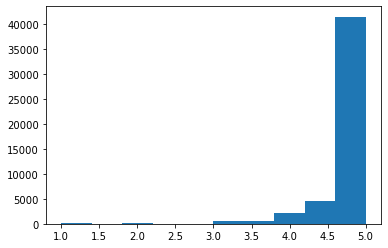

In [193]:
plt.hist(dfu['avg_rating_by_driver'])

In [194]:
dfu['avg_rating_by_driver'].fillna(dfu['avg_rating_by_driver'].median(), inplace=True)

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_1809/1578085505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['avg_rating_by_driver'].fillna(dfu['avg_rating_by_driver'].median(), inplace=True)


In [199]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   surge_pct               50000 non-null  float64
 7   ultimate_black_user     50000 non-null  bool   
 8   weekday_pct             50000 non-null  float64
 9   avg_dist                50000 non-null  float64
 10  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(3)
memory usage: 3.9+ MB


In [202]:
for i in range(len(dfu['ultimate_black_user'])):
    dfu.iloc[i, 7] = int(dfu.iloc[i, 7])

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_1809/1224236347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu.iloc[i, 7] = int(dfu.iloc[i, 7])


### Add Variable for Active Users

In [316]:
dfu['signup_date'] = pd.to_datetime(dfu['signup_date'])
for i in range(len(dfu['last_trip_date'])):
    if dfu.loc[i,'last_trip_date'] >= pd.Timestamp(2014, 6, 1):
        dfu.loc[i, 'active'] = 1
    else:
        dfu.loc[i, 'active'] = 0

In [262]:
df_temp = pd.DataFrame(data1)

In [264]:
dfu['last_trip_date'] = pd.to_datetime(df_temp['last_trip_date'])

#### We can drop the two datetime objects for training

In [271]:
dft = dfu[[i for i in dfu.columns if i not in ['signup_date', 'last_trip_date']]]
dft['ultimate_black_user'] = dft['ultimate_black_user'].astype(float)

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_1809/3059220780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['ultimate_black_user'] = dft['ultimate_black_user'].astype(float)


In [272]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   surge_pct               50000 non-null  float64
 5   ultimate_black_user     50000 non-null  float64
 6   weekday_pct             50000 non-null  float64
 7   avg_dist                50000 non-null  float64
 8   avg_rating_by_driver    50000 non-null  float64
 9   active                  50000 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 3.8+ MB


In [273]:
one_hot = pd.get_dummies(dft['city'])
# Drop column B as it is now encoded
dft = dft.drop('city',axis = 1)
# Join the encoded df
dft = dft.join(one_hot)

In [274]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  float64
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active                  50000 non-null  float64
 9   Astapor                 50000 non-null  uint8  
 10  King's Landing          50000 non-null  uint8  
 11  Winterfell              50000 non-null  uint8  
dtypes: float64(8), int64(1), uint8(3)
memory usage: 3.6 MB


In [275]:
dft

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,Astapor,King's Landing,Winterfell
0,4,4.7,1.10,15.4,1.0,46.2,3.67,5.0,0.0,0,1,0
1,0,5.0,1.00,0.0,0.0,50.0,8.26,5.0,0.0,1,0,0
2,3,4.3,1.00,0.0,0.0,100.0,0.77,5.0,0.0,1,0,0
3,9,4.6,1.14,20.0,1.0,80.0,2.36,4.9,0.0,0,1,0
4,14,4.4,1.19,11.8,0.0,82.4,3.13,4.9,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,0.0,100.0,5.63,4.2,0.0,0,1,0
49996,1,4.9,1.00,0.0,0.0,0.0,0.00,4.0,0.0,1,0,0
49997,0,5.0,1.00,0.0,1.0,100.0,3.86,5.0,0.0,0,0,1
49998,2,3.0,1.00,0.0,0.0,100.0,4.58,3.5,0.0,1,0,0


In [292]:
dft['days_signed_up'] = [i[0] for i in (pd.to_datetime(df_temp['last_trip_date']) - pd.to_datetime(df_temp['signup_date'])).astype(str).str.split(' ')]

In [291]:
(pd.to_datetime(df_temp['last_trip_date']) - pd.to_datetime(df_temp['signup_date'])).astype(str).str.split(' ')

0        [143, days]
1         [96, days]
2          [1, days]
3        [170, days]
4         [47, days]
            ...     
49995    [131, days]
49996      [1, days]
49997    [111, days]
49998      [1, days]
49999     [92, days]
Length: 50000, dtype: object

In [295]:
dft.days_signed_up = dft.days_signed_up.astype(int)

In [299]:
dft = dft.rename(columns={"days_signed_up": "active_until_last"})

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Dropped the phone variable, since it's a useless categorical variable for our model. For our training purposes, we also took away the datetime variables. For missing variables, we replaced the avg_rating_by_driver nad avg_rating_of_driver by their respective columns' medians. At the end, 37% of the population is retained

In [343]:
df_is_retained = dft[dft.active==1.0]

In [344]:
df_is_retained.shape[0]/len(dft)

0.37608

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

The model we chose is logistic regression, in which we will use the recall, accuracy, and r2 as our metric for selection. The reason for choosing logistic regression is that we have two outcomes for our target variable. We choose active after 6 months as our target variable which is that if the last active date is more than 5 months bigger than the sign up date, then that varialbe is considered to be 1 and 0 otherwise.

In [353]:
df_is_retained['active_after_6'] = df_is_retained.active
for i in range(len(df_is_retained)):
    if df_is_retained.iloc[i,-2] > (30*3 + 31*2):
        df_is_retained.iloc[i,-1] = 1
    else:
        df_is_retained.iloc[i,-1] = 0       

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_1809/3851708393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_is_retained['active_after_6'] = df_is_retained.active


In [355]:
df_is_retained

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,Astapor,King's Landing,Winterfell,active_until_last,active_after_6
0,4,4.7,1.10,15.4,1.0,46.2,3.67,5.0,1.0,0,1,0,143,0.0
3,9,4.6,1.14,20.0,1.0,80.0,2.36,4.9,1.0,0,1,0,170,1.0
5,2,3.5,1.00,0.0,1.0,100.0,10.56,5.0,1.0,0,0,1,148,0.0
13,0,4.0,1.38,50.0,0.0,50.0,3.04,5.0,1.0,0,1,0,130,0.0
16,1,5.0,1.00,0.0,1.0,50.0,10.86,3.0,1.0,0,1,0,168,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49976,0,2.0,1.00,0.0,0.0,100.0,2.39,4.0,1.0,0,1,0,161,1.0
49988,1,4.5,1.00,0.0,0.0,50.0,2.53,5.0,1.0,0,1,0,145,0.0
49991,0,5.0,1.25,100.0,0.0,0.0,1.06,5.0,1.0,0,0,1,172,1.0
49993,3,4.8,1.11,11.1,1.0,55.6,2.53,4.7,1.0,1,0,0,179,1.0


In [358]:
df_is_retained.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18804 entries, 0 to 49995
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  18804 non-null  int64  
 1   avg_rating_of_driver    18804 non-null  float64
 2   avg_surge               18804 non-null  float64
 3   surge_pct               18804 non-null  float64
 4   ultimate_black_user     18804 non-null  float64
 5   weekday_pct             18804 non-null  float64
 6   avg_dist                18804 non-null  float64
 7   avg_rating_by_driver    18804 non-null  float64
 8   active                  18804 non-null  float64
 9   Astapor                 18804 non-null  uint8  
 10  King's Landing          18804 non-null  uint8  
 11  Winterfell              18804 non-null  uint8  
 12  active_until_last       18804 non-null  int64  
 13  active_after_6          18804 non-null  float64
dtypes: float64(9), int64(2), uint8(3)
memo

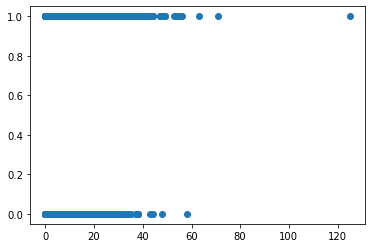

In [357]:
plt.scatter(df_is_retained.trips_in_first_30_days, df_is_retained.active_after_6)

In [360]:
X = df_is_retained[[i for i in df_is_retained.columns if i not in ['active_after_6', 'active']]]
y = df_is_retained['active_after_6']

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [365]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=123)

In [368]:
lr = LogisticRegression()
pipe_lr = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    lr
)

k = [k+1 for k in range(len(X_tr.columns))]
grid_params_lr = {'selectkbest__k': k}


In [370]:
lr_grid_cv = GridSearchCV(pipe_lr, param_grid=grid_params_lr, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_tr, y_tr)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fcf590809d0>)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12]})

In [373]:
best_lr_estimator = lr_grid_cv.best_estimator_

In [374]:
best_lr_estimator

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=1,
                             score_func=<function f_regression at 0x7fcf590809d0>)),
                ('logisticregression', LogisticRegression())])

In [378]:
ss = StandardScaler()
X_tr = ss.fit_transform(X_tr)
X_te = ss.transform(X_te)

In [379]:
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)
y_pr = lr.predict(X_te)

In [385]:
lr.coef_

array([[-3.15197423e-02,  2.49449346e-02,  1.91834952e-02,
        -4.46243540e-02,  2.65547563e-02, -1.06023702e-01,
        -2.18406457e-02,  2.52667429e-02, -2.26508354e-04,
        -5.37198143e-03,  5.32748699e-03,  2.15191621e+01]])

In [393]:
X.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'Astapor', 'King's Landing', 'Winterfell',
       'active_until_last'],
      dtype='object')

In [421]:
list_co = lr.coef_[0].astype(str)

In [422]:
len(list_co)

12

In [423]:
d = {'col': ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist','avg_rating_by_driver', 'Astapor', "King's Landing", 'Winterfell','active_until_last'], 'coef':list_co}
df_co = pd.DataFrame(d, columns=['col','coef'])

In [427]:
df_co.sort_values('coef', ascending=False)

,col,coef
11,active_until_last,21.51916213735199
4,ultimate_black_user,0.026554756265646556
7,avg_rating_by_driver,0.025266742867342172
1,avg_rating_of_driver,0.024944934550245927
2,avg_surge,0.019183495233098934
10,Winterfell,0.005327486994285237
5,weekday_pct,-0.10602370191501233
3,surge_pct,-0.04462435400060479
0,trips_in_first_30_days,-0.03151974232277906
6,avg_dist,-0.021840645671336482


In [380]:
print("Accuracy score: ", accuracy_score(y_pr, y_te))

Accuracy score:  1.0


In [383]:
y_tr_pred_lr = lr.predict(X_tr)
y_te_pred_lr = lr.predict(X_te)
median_r2_simple_lr = r2_score(y_tr, y_tr_pred_lr), r2_score(y_te, y_te_pred_lr)
print(median_r2_simple_lr)

(1.0, 1.0)


In [384]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te, y_pr)

array([[1510,    0],
       [   0, 2251]])

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

From our model, we can see that being active is certainly important for a user to remain active after 5 months and consequently improve the retention rate. Moreover, attribute like active_until_last seems to play a huge factor.